<a href="https://colab.research.google.com/github/TroyWorkPublic/tibaml0922/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import zipfile 
f = zipfile.ZipFile("/content/drive/MyDrive/train.zip")
f.extractall()

KeyboardInterrupt: ignored

In [20]:
import glob #協助找尋符合樣式的路徑
import pandas as pd
dogs = glob.glob("train/dog.*")
cats = glob.glob("train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,train/dog.5450.jpg,0
1,train/dog.1933.jpg,0
2,train/dog.8744.jpg,0
3,train/dog.2438.jpg,0
4,train/dog.5943.jpg,0
...,...,...
24995,train/cat.8920.jpg,1
24996,train/cat.1859.jpg,1
24997,train/cat.8150.jpg,1
24998,train/cat.8976.jpg,1


In [21]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
for l in cnn.layers:
  l.trainable= False #false 將每一層省略，不訓練
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [22]:
# y: 做one-hot encoding很耗費ram, 直接使用Sparse省RAM又方便
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

[[[ -83.939       80.221      130.32     ]
  [ -79.939       80.221      130.32     ]
  [ -68.939       87.221      131.32     ]
  ...
  [ -17.939003    -3.7789993   15.32     ]
  [ -21.939003    -2.7789993   10.32     ]
  [ -23.939003     5.2210007    6.3199997]]

 [[ -82.939       78.221      131.32     ]
  [ -81.939       76.221      131.32     ]
  [ -76.939       77.221      130.32     ]
  ...
  [ -16.939003    -1.7789993   16.32     ]
  [ -17.939003    -1.7789993   12.32     ]
  [ -13.939003     6.2210007    9.32     ]]

 [[ -98.939       54.221      124.32     ]
  [ -93.939       57.221      126.32     ]
  [ -85.939       61.221      126.32     ]
  ...
  [ -11.939003     4.2210007   20.32     ]
  [ -10.939003     3.2210007   14.32     ]
  [  -5.939003     4.2210007    8.32     ]]

 ...

 [[-103.939     -113.779     -122.68     ]
  [-103.939     -115.779     -122.68     ]
  [-103.939     -114.779     -121.68     ]
  ...
  [ -44.939003   -47.779      -22.68     ]
  [ -55.939003   -

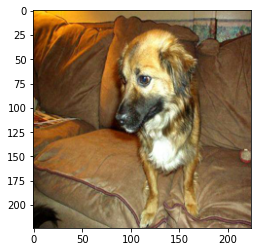

In [23]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

p = df["path"]
idx = random.randint(0, len(p)-1)
img = Image.open(p[idx]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_pre = preprocess_input(img_np)
print(img_np_pre)
plt.imshow(img)

In [24]:
x = np.array(df["path"])
y = np.array(df["ans"])

In [25]:
def data_generator(x, y, batch_size=20): #batch_size->每次給20張圖
    while True:
      idx = np.random.randint(0, len(x), size=batch_size)
      x_batch, y_batch = x[idx], y[idx]
      x_final = []
      for path in x_batch:
        img = Image.open(path).resize((224, 224)).convert("RGB")
        img_pre = preprocess_input(np.array(img))
        x_final.append(img_pre)
      x_final = np.array(x_final)
      y_batch = np.array(y_batch)
      yield (x_final, y_batch)
gen = data_generator(x, y)
x_gen, y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
# print(x_gen)
# print(y_gen)


(20, 224, 224, 3)
(20,)


In [26]:
from sklearn.model_selection import train_test_split
dogx = x[y == 0]
catx = x[y == 1]
dog1000 = np.random.choice(dogx, 1000, replace=False)
dog900, dog100 = train_test_split(dog1000, test_size=0.1)
cat1000 = np.random.choice(catx, 1000, replace=False)
cat900, cat100 = train_test_split(cat1000, test_size=0.1)
x_train = np.concatenate((dog900, cat900))
y_train = np.array([0] * len(dog900) + [1] * len(cat900))
x_test = np.concatenate((dog100, cat100))
y_test = np.array([0] * len(dog100) + [1] * len(cat100))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800,)
(200,)
(1800,)
(200,)


In [27]:
train_generator = data_generator(x_train, y_train)
test_generator = data_generator(x_test, y_test)

In [28]:
# 50 * 20 -> 訓練
# 5 * 20 -> 測試
model.fit_generator(train_generator,
          steps_per_epoch=50,
          epochs=5,
          validation_data=test_generator,
          validation_steps=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 [==============================] - 12s 234ms/step - loss: 0.4418 - accuracy: 0.8230 - val_loss: 0.1956 - val_accuracy: 0.9800
Epoch 2/5
50/50 [==============================] - 11s 227ms/step - loss: 0.2219 - accuracy: 0.9370 - val_loss: 0.1448 - val_accuracy: 0.9600
Epoch 3/5
50/50 [==============================] - 11s 227ms/step - loss: 0.1755 - accuracy: 0.9400 - val_loss: 0.1334 - val_accuracy: 0.9600
Epoch 4/5
50/50 [==============================] - 11s 228ms/step - loss: 0.1414 - accuracy: 0.9650 - val_loss: 0.1326 - val_accuracy: 0.9700
Epoch 5/5
50/50 [==============================] - 11s 229ms/step - loss: 0.1387 - accuracy: 0.9520 - val_loss: 0.0451 - val_accuracy: 1.0000


In [29]:
testx, testy = test_generator.__next__()
model.predict(testx)

array([[9.81051922e-01, 1.89480539e-02],
       [4.87534096e-03, 9.95124638e-01],
       [1.93967763e-03, 9.98060286e-01],
       [3.80433276e-02, 9.61956620e-01],
       [2.41254997e-02, 9.75874424e-01],
       [9.99990821e-01, 9.15705368e-06],
       [1.41890850e-02, 9.85810876e-01],
       [3.15395258e-02, 9.68460500e-01],
       [3.97502482e-01, 6.02497518e-01],
       [9.97951686e-01, 2.04839325e-03],
       [1.67117044e-02, 9.83288229e-01],
       [9.16979492e-01, 8.30205530e-02],
       [9.94667172e-01, 5.33285830e-03],
       [5.38700782e-02, 9.46129858e-01],
       [9.99990821e-01, 9.15705368e-06],
       [1.05012041e-02, 9.89498854e-01],
       [9.99891043e-01, 1.08984386e-04],
       [9.99543846e-01, 4.56073700e-04],
       [9.95367765e-01, 4.63229232e-03],
       [6.12852097e-01, 3.87147903e-01]], dtype=float32)

In [30]:
ori_imgs = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs.append(np.array(img))
ori_imgs = np.array(ori_imgs)
preprocess_imgs = preprocess_input(ori_imgs)
pre = model.predict(preprocess_imgs).argmax(axis=1)

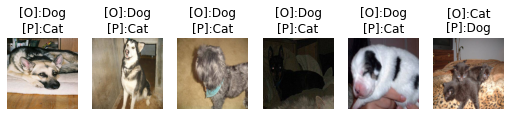

In [31]:
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(15, 15))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

In [32]:
import requests
url = input("Enter:")
response = requests.get(url, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img).reshape(1, 224, 224, 3))
proba = model.predict(img_np)
ans = proba.argmax(axis=1)
print("預測:", trans[ans[0]])
print("機率:", proba[0])
plt.imshow(img)

KeyboardInterrupt: ignored